In [1]:
import torch
import numpy as np
from   recovery import NNLAD
from   noise import GaussianNoise
from   sensing_matrices import ConstructedPooling
import matplotlib.pyplot as plt

/products/anaconda3/envs/glodismo_classifier/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
container   = np.load("data.npz")
Phi         = container["zero_mask"]
sigmas      = container["sigmas"]
taus        = container["taus"]
x           = container["x"]
niterations = len(sigmas)



In [32]:
device='cpu'
X = torch.from_numpy(x)
A = torch.from_numpy(Phi.T)
# A = ConstructedPooling(1).A
# X = X.to(device) 
print(X.shape)
print(A.shape)
print(A.numpy())


torch.Size([1, 961])
torch.Size([248, 961])
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.125 0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


In [33]:
nnlad_sigma= np.exp(sigmas).reshape(1,-1)
nnlad_tau  = np.exp(taus).reshape(1,-1)

model      = NNLAD(niterations,nnlad_sigma,nnlad_tau)
# sparsity domain (not used at the moment in NNLAD)
psi        = lambda x: x
psistar    = lambda y: y

forward_op  = lambda x: torch.matmul(x, A.T)
backward_op = lambda x: torch.matmul(x, A)


noise=GaussianNoise(100)

[[9.9999994e-02 1.0010001e-01 1.0019999e-01 ... 8.8254223e-05
  8.8254223e-05 8.8254223e-05]]


In [34]:
model.sigma[0][0]

0.099999994

In [35]:
# y = noise(forward_op(X))
# scale=1.e7
y = noise(forward_op(X))
scale = torch.max(y)
y = y/scale
Xhat = model(y, forward_op, backward_op, psi, psistar)*scale

0.36593467


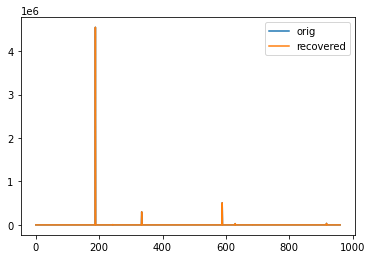

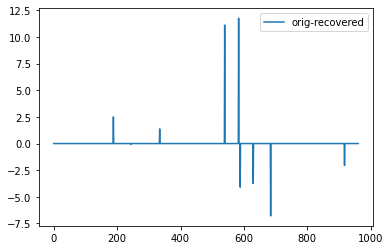

In [36]:

err=X.numpy()-Xhat.numpy()
print(np.mean(err**2))
plt.figure()
plt.plot(X.numpy().T,label='orig')
plt.plot(Xhat.numpy().T,label='recovered')
plt.legend()

plt.figure()
plt.plot(X.numpy().T-Xhat.numpy().T,label='orig-recovered')
plt.legend()